In [122]:
import os
import statistics
import json
import glob
from matplotlib import pyplot as plt
from posixpath import basename
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import matplotlib

In [123]:
discr_dict={'P1':0,'P2':1,'P3':2,'P4':3,'Q1':4,'Q2':5}
# mesh_dict={"square_beam_0.5":0,"square_beam_0.25":1,"square_beam_0.1":2,"square_beam_0.05":3,"square_beam_0.025":4,"square_beam_0.01":5,"square_beam_0.005":6}
# mesh_dict={"square_beam_0.025":0,"square_beam_0.022":1,"square_beam_0.021":2,"square_beam_0.020":3,"square_beam_0.019":4,"square_beam_0.016":5,"square_beam_0.013":6,"square_beam_0.01":7}
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
class Cal_result(object):
    # solver_name="AMGCL"
    # json_name="bar"
    # discr_order=1
    # n_ref=1
    # block_size=1
    # repeat_times=5
    # result_json=[]
    # time=np.zeros((1,repeat_times),dtype=np.double)
    # iter=np.zeros((1,repeat_times),dtype=np.int32)
    # err=np.zeros((1,repeat_times),dtype=np.double)
    def __init__(self,solver_name_,mesh_name_,json_name_,discr_order_,n_ref_,block_size_,repeat_times_,num_thread_):
        self.solver_name=solver_name_
        self.mesh_name=mesh_name_
        self.json_name=json_name_
        self.discr_order=discr_order_
        self.n_ref=n_ref_
        self.block_size=block_size_
        self.repeat_times=repeat_times_
        self.num_thread=num_thread_
        self.result_json=[None]*(repeat_times_+1)
        #From the json file
        self.mat_size=0
        self.nonzero=0
        self.time=np.zeros((1,repeat_times_+1),dtype=np.double)
        self.iter=np.zeros((1,repeat_times_+1),dtype=np.int32)
        self.err=np.zeros((1,repeat_times_+1),dtype=np.double)
    def avg_time(self):
        return np.average(self.time,axis=1)
    def avg_iter(self):
        return np.average(self.iter,axis=1)
    def avg_err(self):
        return np.average(self.err,axis=1)



In [124]:
def get_erriter(solver_name_,json_data_): 
    #return iter,err(0 if not exist,-1 if fail)
    if solver_name_=="AMGCL":
        return json_data_["num_iterations"],json_data_["final_res_norm"]
    if solver_name_=="Eigen::CholmodSupernodalLLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Eigen::ConjugateGradient":
        return json_data_["solver_iter"], json_data_["solver_error"]
    if solver_name_=="Hypre":
        return json_data_["num_iterations"],json_data_["final_res_norm"]
    if solver_name_=="Eigen::PardisoLDLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Eigen::SimplicialLDLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1

In [125]:
def stats(j_file_): 
    #return solving_time,iterations,error,mat_order
    with open(j_file_, 'r') as f:
        json_data = json.load(f)
    solver_name=json_data["args"]["solver_type"]
    tensor_formulation=json_data["args"]["tensor_formulation"]
    mat_size=json_data["mat_size"]
    nonzero=json_data["num_non_zero"]
    time_solving=json_data["time_solving"]
    num_iterations=0
    err=0
    solver_info=json_data["solver_info"]
    if tensor_formulation=="NeoHookean":
        err_list=[]
        iter_list=[]
        for temp in json_data["solver_info"][0]["info"]["internal_solver"]:
            tempiter,temperr=get_erriter(solver_name,temp)
            err_list.append(temperr)
            iter_list.append(tempiter)
        err=statistics.mean(err_list)
        num_iterations=sum(iter_list)
        # Need to verify the mat_order
        return time_solving,num_iterations,err,mat_size,nonzero
    else:
        tempiter,temperr=get_erriter(solver_name,solver_info)
        return time_solving,tempiter,temperr,mat_size,nonzero
    # Add "if" for more problems                

# Prepare data

In [126]:
# path_lists=[glob.glob("results/square/**/**/**/**/**/**"),glob.glob("results/square_pre/**/**/**/**/**/**")]
def data_collect(path_lists,start_index):
    # path_lists=[glob.glob("results/thread_num/**/**/**/**/**/**/**")]
    result_list=[]
    fail_list=[]
    for path_list in path_lists:
        for path in path_list:
            temp_path=path.split('/')
            solver_name=temp_path[0+start_index]
            mesh_name=temp_path[1+start_index]
            json_name=temp_path[2+start_index]
            discr_order=discr_dict[temp_path[3+start_index]]
            n_ref=int(temp_path[4+start_index][-1])
            block_size=int(temp_path[5+start_index][-1])
            if len(temp_path)==7+start_index:
                num_thread=int(temp_path[6+start_index].strip("Thread"))
            else:
                num_thread=32
            repeat_path=glob.glob(os.path.join(path,"*"))
            repeat_times=max(map(int,map(os.path.basename,repeat_path)))
            temp_result=Cal_result(solver_name,mesh_name,json_name,discr_order,n_ref,block_size,repeat_times,num_thread)
            exist_bool=True
            for inner_path in repeat_path:
                repeat_time=int(os.path.basename(inner_path))
                json_path=os.path.join(inner_path,"json","result.json")
                if os.path.exists(json_path):
                    temp_result.time[0,repeat_time],temp_result.iter[0,repeat_time],temp_result.err[0,repeat_time],temp_result.mat_size,temp_result.nonzero=stats(json_path)
                    temp_result.result_json[repeat_time]=inner_path
                else:
                    fail_list.append(inner_path)
                    # print(inner_path+" is empty, corresponding test failed")
                    exist_bool=False
            if exist_bool:
                result_list.append(temp_result)
    return result_list,fail_list

In [127]:
result_list,fail_list=data_collect([glob.glob("results/thread_num/**/**/**/**/**/**/**")],2)
result_max_list,fail_max_list=data_collect([glob.glob("results/thread_max/**/**/**/**/**/**/**")],2)
result_ori_list,fail_ori_list=data_collect([glob.glob("results/square/AMGCL/square_beam_0.016/bar/P2/ref1/**"),glob.glob("results/square/Hypre/square_beam_0.016/bar/P2/ref1/**"),glob.glob("results/square/Eigen::CholmodSupernodalLLT/square_beam_0.016/bar/P2/ref1/**"),glob.glob("results/square/Eigen::PardisoLDLT/square_beam_0.016/bar/P2/ref1/**")],2)

In [128]:
def df_create(result_list):
    columns=["Scene","Solver","Mesh","Mat Size","Nonzeros","discr_order","n_ref","Block Size","Num Thread","Runtime","Error","Iterations"]
    result_df=pd.DataFrame(columns=columns)
    for result,i in zip(result_list,range(len(result_list))):
        df_row={}
        df_row["Scene"]=result.json_name
        df_row["Mesh"]=result.mesh_name
        df_row["Mat Size"]=result.mat_size
        df_row["Nonzeros"]=result.nonzero
        df_row["Solver"]=result.solver_name
        df_row["discr_order"]=result.discr_order
        df_row["n_ref"]=result.n_ref
        df_row["Block Size"]=result.block_size
        df_row["Num Thread"]=result.num_thread
        df_row["Runtime"]=np.average(result.time,axis=1)
        df_row["Error"]=np.average(result.err,axis=1)
        df_row["Iterations"]=np.average(result.iter,axis=1)
        result_df.loc[i]=df_row
    return result_df

In [129]:
result_df=df_create(result_list)
result_max_df=df_create(result_max_list)
result_ori_df=df_create(result_ori_list)

In [135]:
cmap=['b','g','r','c','m','y','k','w']
def plot(solver_name_,block_size_,ax_,df,loc_index_,num_rects_):   
    tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)& (df["discr_order"]==1)]
    tempdf=tempdf.sort_values(by=['Num Thread'])
    xdata=np.int64(tempdf["Num Thread"])
    ydata=np.float64(tempdf["Runtime"])
    if solver_name_=="Eigen::CholmodSupernodalLLT":
        label_="Cholmod"
    elif solver_name_=="Eigen::PardisoLDLT":
        label_="Pardiso"
    else:
        label_=solver_name_+"B"+str(block_size_)
    x=4
    ax_.bar_label(ax_.bar((x-0.4*10+0.8*10/num_rects_*(loc_index_+0.5)),ydata,0.8*10/num_rects_,color=cmap[loc_index_]),padding=3,fmt='%.2f',fontsize=18)
    

In [131]:
def fit(solver_name_,block_size_,ax_,df,cmap_,cindex_):
    degree=1    
    tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)& (df["discr_order"]==1)]
    tempdf=tempdf.sort_values(by=['Num Thread'])
    xdata=np.int64(tempdf["Num Thread"])
    ydata=np.float64(tempdf["Runtime"])
    logx = np.log(xdata)
    logy = np.log(ydata)
    coeffs = np.polyfit(logx,logy,deg=degree)
    poly = np.poly1d(coeffs)
    yfit = lambda x: np.exp(poly(np.log(x)))
    if solver_name_=="Eigen::CholmodSupernodalLLT":
        label_="Cholmod"
    elif solver_name_=="Eigen::PardisoLDLT":
        label_="Pardiso"
    else:
        label_=solver_name_+"B"+str(block_size_)
    ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xtick,yfit(xtick),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_])


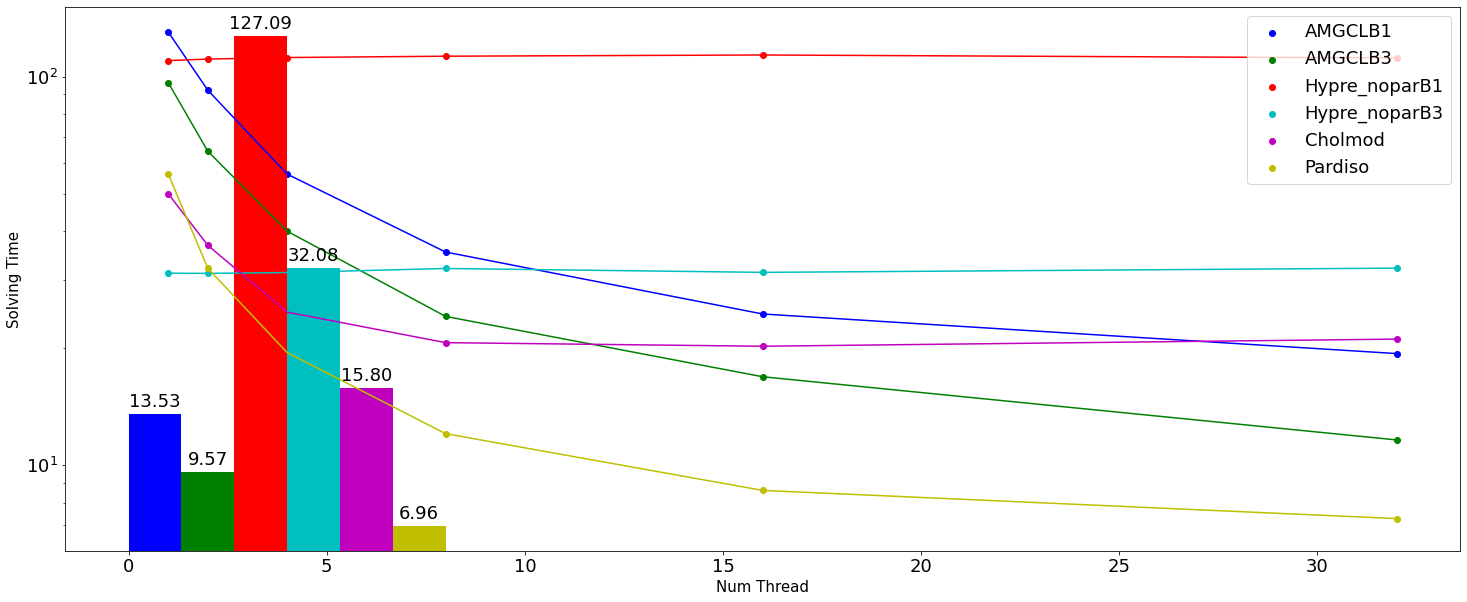

In [138]:
%matplotlib inline
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]

num_threads=np.sort(np.int64(result_df["Num Thread"].unique()))
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel("Num Thread",fontsize=15) # x labels
ax.set_ylabel("Solving Time",fontsize=15) # y labels
fit("AMGCL",1,ax,result_df,cmap,0)
fit("AMGCL",3,ax,result_df,cmap,1)
fit("Hypre_nopar",1,ax,result_df,cmap,2)
fit("Hypre_nopar",3,ax,result_df,cmap,3)
fit("Eigen::CholmodSupernodalLLT",1,ax,result_df,cmap,4)
fit("Eigen::PardisoLDLT",1,ax,result_df,cmap,5)
plot("AMGCL",1,ax,result_ori_df,0,6)
plot("AMGCL",3,ax,result_ori_df,1,6)
plot("Hypre",1,ax,result_ori_df,2,6)
plot("Hypre",3,ax,result_ori_df,3,6)
plot("Eigen::CholmodSupernodalLLT",1,ax,result_ori_df,4,6)
plot("Eigen::PardisoLDLT",1,ax,result_ori_df,5,6)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.legend()

# plt.xscale("log") # log scale
plt.yscale("log") # log scale

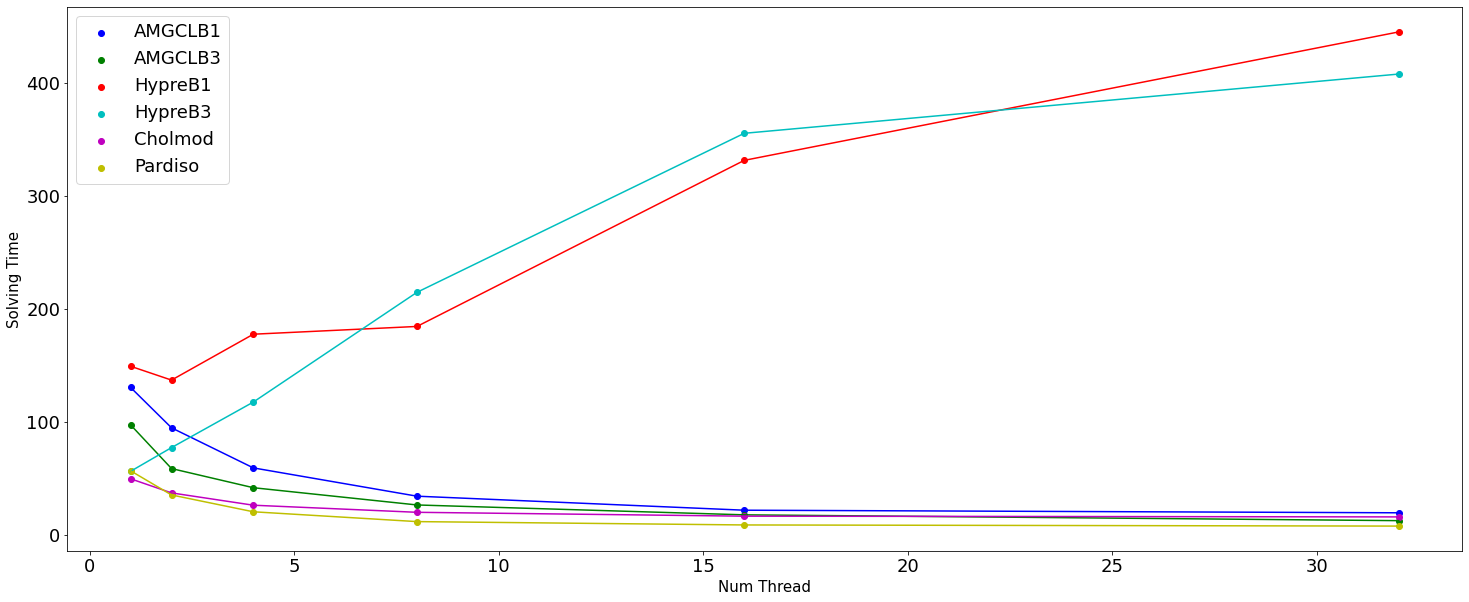

In [66]:
%matplotlib inline
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
cmap=['b','g','r','c','m','y','k','w']
num_threads=np.sort(np.int64(result_df["Num Thread"].unique()))
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel("Num Thread",fontsize=15) # x labels
ax.set_ylabel("Solving Time",fontsize=15) # y labels
fit("AMGCL",1,ax,result_max_df,cmap,0)
fit("AMGCL",3,ax,result_max_df,cmap,1)
fit("Hypre",1,ax,result_max_df,cmap,2)
fit("Hypre",3,ax,result_max_df,cmap,3)
fit("Eigen::CholmodSupernodalLLT",1,ax,result_max_df,cmap,4)
fit("Eigen::PardisoLDLT",1,ax,result_max_df,cmap,5)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.legend()

# plt.xscale("log") # log scale
# plt.yscale("log") # log scale

# Bar

/tmp/ipykernel_1833976/1111504715.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,1,2,4,8,16,32])


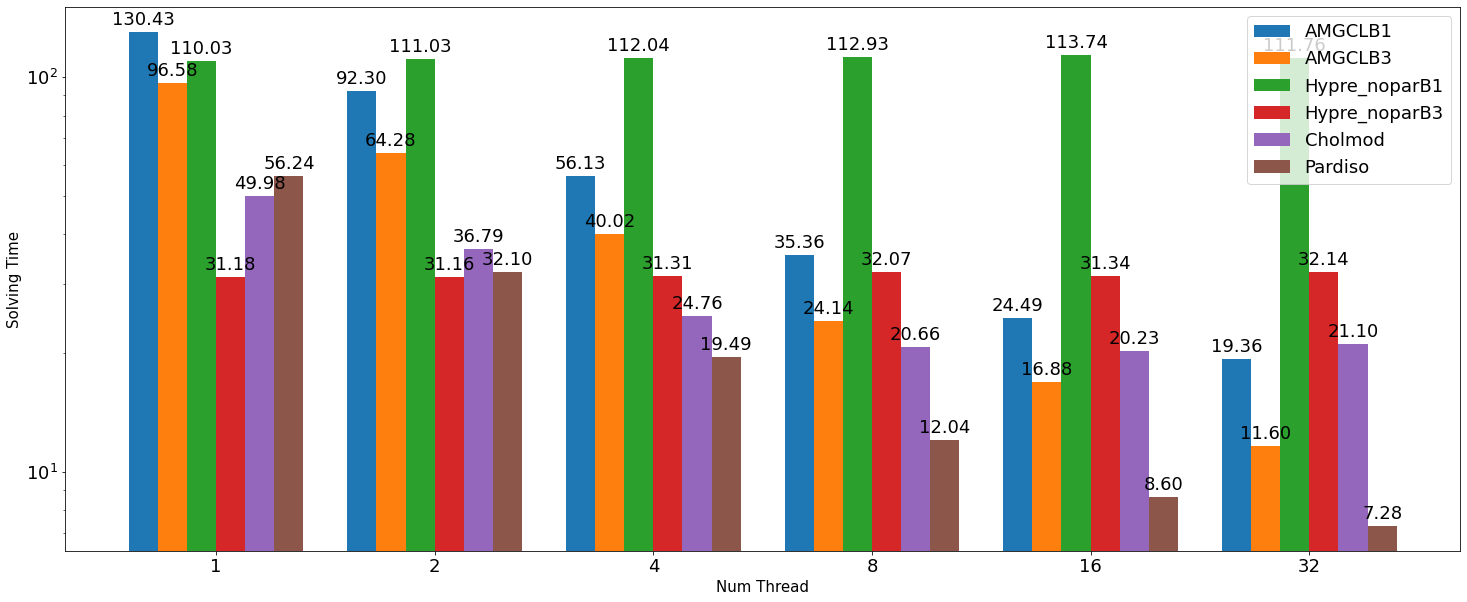

In [ ]:
%matplotlib inline
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
cmap=['b','g','r','c','m','y','k','w']
num_threads=np.sort(np.int64(result_df["Num Thread"].unique()))
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel("Num Thread",fontsize=15) # x labels
ax.set_ylabel("Solving Time",fontsize=15) # y labels
plot("AMGCL",1,ax,result_df,0,6)
plot("AMGCL",3,ax,result_df,1,6)
plot("Hypre_nopar",1,ax,result_df,2,6)
plot("Hypre_nopar",3,ax,result_df,3,6)
plot("Eigen::CholmodSupernodalLLT",1,ax,result_df,4,6)
plot("Eigen::PardisoLDLT",1,ax,result_df,5,6)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.legend()
ax.set_xticklabels([0,1,2,4,8,16,32])
plt.yscale("log") # log scale